In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

print(os.listdir())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


In [45]:
import numpy as np
import matplotlib
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn import ensemble
from sklearn.feature_selection import SelectFromModel
from os import listdir
from os.path import isfile, join
from skimage.io import imread
from skimage.color import rgb2grey
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.feature import hog

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
#access main dir
patch_dir = '/content/gdrive/MyDrive/Patch1k'
# hair_dir = '/content/gdrive/MyDrive/Patch1k/Hair'
# nonhair_dir = '/content/gdrive/MyDrive/Patch1k/NonHair'

#access path for hair and nonhair
hair_non_hair = [join(patch_dir, 'Hair' ),join(patch_dir, 'NonHair')]
# hair_non_hair = [join(patch_dir, hair_dir ),join(patch_dir, nonhair_dir)]
#initialise list of paths
train_images_paths = []
test_images_paths = []
train_labels = []
test_labels = []
for i, dir in enumerate(hair_non_hair):
  #get paths to test and train path within each hair and nonhair dirs
  test_dir = join(dir, 'Testing')
  train_dir = join(dir, 'Training')
  # test_dir = '/content/gdrive/MyDrive/Patch1k/Hair/Testing'
  # train_dir = '/content/gdrive/MyDrive/Patch1k/Hair/Training'
  #loop style taken from stackoverflow https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
  train_images_paths += [join(train_dir, f) for f in listdir(train_dir) if isfile(join(train_dir, f))]
  test_images_paths += [join(test_dir, f) for f in listdir(test_dir) if isfile(join(test_dir, f))]
  #assign label to paths
  train_labels += [i]*len(listdir(train_dir))
  test_labels += [i]*len(listdir(test_dir))
  # print(train_images_paths[0])





In [48]:
def paths_to_images(image_paths):
  """
  This function converts paths to images and returns a stack of images
  """
  #initialise stack of images with each image just being 227x227 zeros
  images = np.zeros((len(image_paths),227,227))
  #looping through list of paths and converting to list of images
  for i, path in enumerate(image_paths):
        image = imread(path)
        #if image in colour tranform into black and white
        if len(image.shape) == 3:
            image = rgb2grey(image)
        images[i,:,:] = image
  return images

In [49]:
# #images in own arrays from files
# # stack of train images
# train_images = paths_to_images(train_images_paths)
# #stack of test images
# test_images = paths_to_images(test_images_paths)

# # (train_X, train_y), (test_X, test_y) = mnist.load_data()

# #save image patches and labels for easier access
# np.save('/content/gdrive/MyDrive/train_images_patch',train_images)
# np.save('/content/gdrive/MyDrive/test_images_patch',test_images)
# np.save('/content/gdrive/MyDrive/train_labels_patch', train_labels)
# np.save('/content/gdrive/MyDrive/test_labels_patch', test_labels)



In [50]:
#load saved image patches and labels and shuffle so not memorised

train_images = np.load('/content/gdrive/MyDrive/train_images_patch.npy')
train_labels = np.load('/content/gdrive/MyDrive/train_labels_patch.npy')
train_images, train_labels = shuffle(train_images, train_labels)

test_images = np.load('/content/gdrive/MyDrive/test_images_patch.npy')
test_labels = np.load('/content/gdrive/MyDrive/test_labels_patch.npy')
test_images, test_labels = shuffle(test_images, test_labels)

In [51]:
#Get tiny feats
def get_tiny_feats(images):
  """
  This function downsamples images and stacks them
  """
  #initialise stack of images with each image just being 16x16 zeros
  tiny_images = np.zeros((len(images),16,16))
  #looping through list of paths and converting to list of images
  for i, image in enumerate(images):        
        resized_image = resize(image, (16,16), anti_aliasing=True)
        tiny_images[i,:,:] = resized_image
  return tiny_images


In [61]:
#get tiny feats
tiny_train_feats = get_tiny_feats(train_images)
tiny_test_feats = get_tiny_feats(test_images)


tiny_train_feats = np.reshape(tiny_train_feats, (train_images.shape[0],-1))
tiny_test_feats = np.reshape(tiny_test_feats, (test_images.shape[0],-1))

In [68]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(tiny_train_feats, train_labels)
svm.score(tiny_test_feats, test_labels)

0.8476190476190476

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(tiny_train_feats, train_labels)
knn.score(tiny_test_feats, test_labels)

0.7833333333333333

([<matplotlib.axis.XTick at 0x7fbdef291390>,
 <a list of 5 Text major ticklabel objects>)

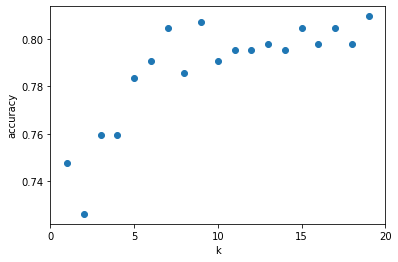

In [63]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(tiny_train_feats, train_labels)
    scores.append(knn.score(tiny_test_feats, test_labels))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [55]:
#Get hog feats
def get_hog_feats(images):
  """
  This function creates hog descriptors of the patches
  """
  z=2
  y=5
  descriptors_stack = []
  for i, image in enumerate(images):
    hog_descriptor = hog(image,pixels_per_cell=(y,y), cells_per_block=(z,z), feature_vector=True )
    #this makes it 2d 
    hog_descriptor.reshape((-1,len(hog_descriptor)))
    descriptors_stack.append(hog_descriptor)
  return descriptors_stack



In [57]:
#get hog feats
hog_train_feats = get_hog_feats(train_images)
hog_test_feats = get_hog_feats(test_images)

hog_train_feats = np.reshape(hog_train_feats, (train_images.shape[0],-1))
hog_test_feats = np.reshape(hog_test_feats, (test_images.shape[0],-1))


In [66]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(hog_train_feats, train_labels)
svm.score(hog_test_feats, test_labels)

0.8690476190476191

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(hog_train_feats, train_labels)
knn.score(hog_test_feats, test_labels)

0.7261904761904762

([<matplotlib.axis.XTick at 0x7fbdef1484d0>,
 <a list of 5 Text major ticklabel objects>)

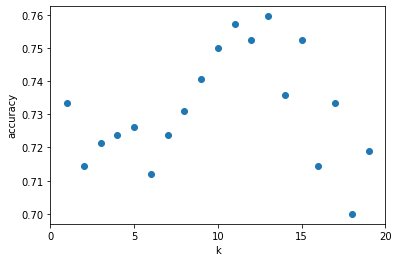

In [67]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(hog_train_feats, train_labels)
    scores.append(knn.score(hog_test_feats, test_labels))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])